## Lasso Regression
Based on the linear model we have built, we know some features are unimportant. To shrink some feature's parameters into zero, we introduce $l_1$ penalty into the objective function.
<img src="https://latex.codecogs.com/gif.latex?\begin{align*}&space;L&space;&=&space;\frac{1}{2N}&space;\sum_{i}^N(y_i&space;-&space;\hat&space;y_i)^2&space;&plus;&space;\lambda&space;\sum_{i=1}^{p&plus;1}|\beta_i|&space;\\&space;&=&space;\frac{1}{2N}&space;\sum_{i=1}^{N}&space;(y_i&space;-&space;\sum_{j=1}^{p&plus;1}&space;{x_{ij}&space;\beta_j})^2&space;&plus;&space;\lambda&space;\sum_{j=1}^{p&plus;1}|\beta_j|&space;\\&space;&=&space;\frac{1}{2N}&space;||Y&space;-&space;X\beta||^2&space;&plus;&space;\lambda&space;||\beta||_1&space;\end{align*}" title="\begin{align*} L &= \frac{1}{2N} \sum_{i}^N(y_i - \hat y_i)^2 + \lambda \sum_{i=1}^{p+1}|\beta_i| \\ &= \frac{1}{2N} \sum_{i=1}^{N} (y_i - \sum_{j=1}^{p+1} {x_{ij} \beta_j})^2 + \lambda \sum_{j=1}^{p+1}|\beta_j| \\ &= \frac{1}{2N} ||Y - X\beta||^2 + \lambda ||\beta||_1 \end{align*}" />

## Data Generator
We use the boston house price dataset. In preprocessing, to eliminate intercepet, we expand  X
 's dim and scale each feature's mean to zero and each feature's std to unit.

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline

In [2]:
x, y = load_boston(return_X_y=True)
m = x.shape[0]
inter = np.ones([m, 1]) # intercept
x = np.hstack((x, inter))
x.shape, y.shape

((506, 14), (506,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2018)
y_train, y_test = np.expand_dims(y_train, 1), np.expand_dims(y_test, 1)
X_train.shape, y_train.shape

((379, 14), (379, 1))

In [4]:
# Stand Normalization
x_scale = preprocessing.StandardScaler()
x_scale.fit(X_train)
X_train_, X_test_ = x_scale.transform(X_train), x_scale.transform(X_test)

y_scale = preprocessing.StandardScaler()
y_scale.fit(y_train)
y_train_, y_test_ = y_scale.transform(y_train), y_scale.transform(y_test)

## Coordinate Descent

### Sinlge Predictor
First, consider there is only one variable $\beta_j$ in objetive function.
<img src="https://latex.codecogs.com/gif.latex?\min_{\beta_j}&space;\frac{1}{2N}&space;\sum_{i=1}^{N}&space;(y_i&space;-{z_j&space;\beta_j})^2&space;&plus;&space;\lambda&space;|\beta_j|" title="\min_{\beta_j} \frac{1}{2N} \sum_{i=1}^{N} (y_i -{z_j \beta_j})^2 + \lambda |\beta_j|" />
This a quadratic optimization problem over single variable. We could get the closed-form solution.
<img src="https://latex.codecogs.com/gif.latex?\beta_j^*=\left\{\begin{matrix}&space;\frac{1}{N}&space;\langle&space;z,&space;y&space;\rangle&space;-&space;\lambda&space;&&space;\mathrm{if&space;\,}&space;\frac{1}{N}&space;\langle&space;z,&space;y&space;\rangle&space;>&space;\lambda\\&space;0&&space;\mathrm&space;{otherwise&space;\,}\\&space;\frac{1}{N}&space;\langle&space;z,&space;y&space;\rangle&space;&plus;&space;\lambda&space;&&space;\mathrm{if&space;\,}&space;\frac{1}{N}&space;\langle&space;z,&space;y&space;\rangle&space;<&space;-\lambda&space;\end{matrix}\right." title="\beta_j^*=\left\{\begin{matrix} \frac{1}{N} \langle z, y \rangle - \lambda & \mathrm{if \,} \frac{1}{N} \langle z, y \rangle > \lambda\\ 0& \mathrm {otherwise \,}\\ \frac{1}{N} \langle z, y \rangle + \lambda & \mathrm{if \,} \frac{1}{N} \langle z, y \rangle < -\lambda \end{matrix}\right." />

### Multiple Predictor
For the optimization problem over multiple variables, we could fix the other variable when we optimize a single variable.
<img src="https://latex.codecogs.com/gif.latex?\min_{\beta_j}&space;\frac{1}{2N}&space;\sum_{i=1}^{N}&space;(y_i&space;-&space;\sum_{k&space;\ne&space;j}x_{ik}\beta_k&space;-&space;{x_{ij}&space;\beta_j})^2&space;&plus;&space;\lambda&space;\sum_{k&space;\ne&space;j}&space;|\beta_k|&space;&plus;&space;\lambda&space;|\beta_j|" title="\min_{\beta_j} \frac{1}{2N} \sum_{i=1}^{N} (y_i - \sum_{k \ne j}x_{ik}\beta_k - {x_{ij} \beta_j})^2 + \lambda \sum_{k \ne j} |\beta_k| + \lambda |\beta_j|" />

Here is the idea of coordinate descent.

<img src="https://latex.codecogs.com/gif.latex?\begin{align*}&space;&\mathrm{Repeat\{}&space;\\&space;&\quad&space;\mathrm{For\,&space;each\,&space;j&space;=&space;1,&space;2,&space;\cdots,&space;p&plus;1}&space;\{\\&space;&\qquad&space;\mathrm{compute&space;\,&space;residual\,}&space;r_j&space;:=&space;y&space;-&space;\sum_{k&space;\ne&space;j}&space;x_ik&space;\beta_k&space;\\&space;&\qquad&space;\mathrm{update\,}&space;\beta_j&space;:=&space;S_\lambda(\frac{1}{N}&space;\langle&space;x_j,&space;r_j&space;\rangle)&space;\\&space;&\quad\}&space;\\&space;&\}&space;\end{align}" title="\begin{align*} &\mathrm{Repeat\{} \\ &\quad \mathrm{For\, each\, j = 1, 2, \cdots, p+1} \{\\ &\qquad \mathrm{compute \, residual\,} r_j := y - \sum_{k \ne j} x_ik \beta_k \\ &\qquad \mathrm{update\,} \beta_j := S_\lambda(\frac{1}{N} \langle x_j, r_j \rangle) \\ &\quad\} \\ &\} \end{align}" />


In [5]:
def soft_shrink(x, residual, indices=None, coef=1.0):
    N = x.shape[0]
    if indices is None:
        res = np.dot(residual, x)/N
    else:
        res = np.dot(residual, x[:, indices])/N
    if res < -coef:
        beta = res + coef
    elif res > coef:
        beta = res - coef
    else:
        beta = 0
    return beta

In [6]:
def compute_residual(x, y, beta, indices):
    residual = (y - np.dot(x, beta)).flatten()
    residual += x[:, indices] * beta[indices]
    return residual

In [7]:
coef = 0.1
n_iter = 100
p = X_train.shape[1]
beta = np.random.randn(p, 1)
errors = []
for i in range(n_iter):
    for j in range(p):
        residual = compute_residual(X_train_, y_train_, beta, j)
        beta[j] = soft_shrink(X_train_, residual, j, coef)
    y_hat_train_ = np.dot(X_train_, beta)
    y_hat_train = y_scale.inverse_transform(y_hat_train_)
    train_error = np.sum(np.square(y_hat_train - y_train))/(2*X_train.shape[0])
    errors.append(train_error)
print("Important Feature:", np.where(beta.flatten()!=0))
beta

Important Feature: (array([ 3,  5, 10, 11, 12]),)


array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.02057756],
       [ 0.        ],
       [ 0.27254509],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.12531364],
       [ 0.01722227],
       [-0.42216088],
       [ 0.        ]])

### Coordinate Descent is a fast algorithm!

Text(0,0.5,'train error')

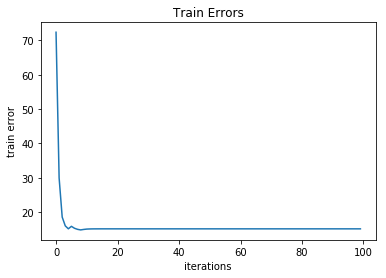

In [8]:
plt.plot(errors)
plt.title("Train Errors")
plt.xlabel("iterations")
plt.ylabel("train error")

('Lasso Train Error', 15.12079856935791)

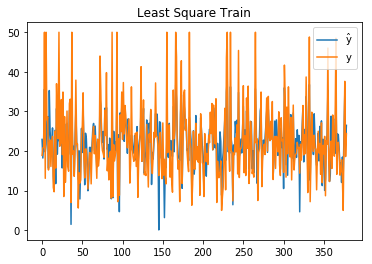

In [9]:
y_hat_train_ = np.dot(X_train_, beta)
y_hat_train = y_scale.inverse_transform(y_hat_train_)
plt.plot(y_hat_train, label="$\mathrm{\hat y}$")
plt.plot(y_train, label="$\mathrm{y}$")
plt.title("Least Square Train")
plt.legend()
train_error = np.sum(np.square(y_hat_train - y_train))/(2*X_train.shape[0])
"Lasso Train Error", train_error

('Lasso Test Error', 11.123229916213154)

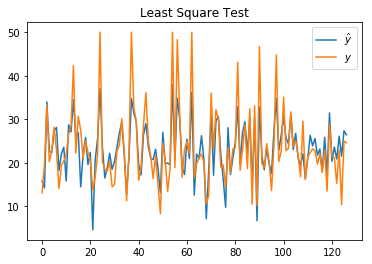

In [10]:
y_hat_test_ = np.dot(X_test_, beta)
y_hat_test = y_scale.inverse_transform(y_hat_test_)
plt.plot(y_hat_test, label="$\hat y$")
plt.plot(y_test, label="$y$")
plt.title("Least Square Test")
plt.legend()
test_error = np.sum(np.square(y_hat_test - y_test))/(2*y_test.shape[0])
"Lasso Test Error", test_error

## From Lasso To Least Square

In [11]:
t = np.array(np.arange(1, -5, -1))
coefs = np.exp(t)

In [12]:
n_iter = 100
p = X_train.shape[1]

betas = np.zeros([coefs.shape[0], p])
beta = np.random.randn(p, 1)
for indices,coef in enumerate(coefs):
    for i in range(n_iter):
        for j in range(p):
            residual = compute_residual(X_train_, y_train_, beta, j)
            beta[j] = soft_shrink(X_train_, residual, j, coef)
    betas[indices, :] = beta.flatten()

### When $\lambda$ decreases, model changes from Lasso to Least Square 

Text(0.5,0,'$\\lambda$')

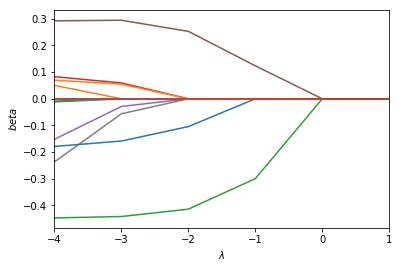

In [13]:
plt.figure()
for i in range(p):
    plt.plot(t, betas[:, i])
plt.xticks(t)
plt.xlim([np.min(t), np.max(t)])
plt.ylabel("$beta$")
plt.xlabel("$\lambda$")